In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from uc_data import UCIrvineDatasetDynamic, UCIrvineDataset
import torch.nn.functional as F
from poker_utils.model import plot_train_loss
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# X = pd.read_csv("data/uc_irvine/X.csv")
# y = pd.read_csv("data/uc_irvine/y.csv")
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.6, random_state=29, stratify=y['CLASS']
#     )
# X_train = X_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# X_val = X_val.reset_index(drop=True)
# y_val = y_val.reset_index(drop=True)
# train_dataset = UCIrvineDatasetDynamic(X_train, y_train)
# val_dataset = UCIrvineDatasetDynamic(X_val, y_val)

# trainloader = DataLoader(
#     train_dataset,
#     batch_size=128,
#     shuffle=True,
#     num_workers=4,   
#     pin_memory=True,
#     drop_last=True
# )
# valloader = DataLoader(
#     val_dataset,
#     batch_size=128,
#     shuffle=False,
#     num_workers=4,   
#     pin_memory=True,
#     drop_last=True
# )

In [18]:
train_dataset = UCIrvineDataset(test_size=0.6, train=True)
val_dataset = UCIrvineDataset(test_size=0.6, train=False)
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [19]:
class TransformerBoardEncoder(nn.Module):
    def __init__(self, card_embeddings, card_dim=16, board_dim=16, num_heads=8, num_layers=2, freeze_emb=True):
        super().__init__()
        padding_row = torch.zeros((1, card_embeddings.size(1)))
        card_embeddings_padded = torch.cat([card_embeddings, padding_row], dim=0) 
        self.card_embedder = nn.Embedding.from_pretrained(
            card_embeddings_padded, padding_idx=52, freeze=freeze_emb)
        self.card_cls_tok = nn.Parameter(torch.randn(1, 1, card_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=card_dim,
            nhead=num_heads,
            dropout=0.1,
            dim_feedforward=2*card_dim,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(card_dim, board_dim)

    def forward(self, board_ids):
        """
        card_ids: [B, L] where L <= 5, -1 for padding
        """
        B, L = board_ids.shape
        mask = (board_ids != -1)
        safe_ids = board_ids.masked_fill(~mask, 52)
        card_emb = self.card_embedder(safe_ids)
        card_cls_tok = self.card_cls_tok.expand(B, 1, -1)
        card_emb = torch.cat([card_cls_tok, card_emb], dim=1)
        
        pad_mask = torch.cat([torch.zeros(B, 1, dtype=torch.bool), ~mask], dim=1)
        x_transformed = self.transformer(card_emb, src_key_padding_mask=pad_mask)
        cls_out = x_transformed[:, 0, :]
        return self.output_proj(cls_out)
    

In [20]:
class HandStrengthPredictor(nn.Module):
    def __init__(self, card_embeddings, card_dim=16, board_dim=16, num_heads=8, num_layers=2, freeze_emb=True):
        super().__init__()
        self.board_encoder = TransformerBoardEncoder(
            card_embeddings,
            card_dim=card_dim, 
            board_dim=board_dim, 
            num_heads=num_heads, 
            num_layers=num_layers,
            freeze_emb=freeze_emb
            )
        
        # self.model_layer = nn.Sequential(
        #     nn.Linear(board_dim, board_dim),
        #     nn.ReLU(),
        #     nn.Linear(board_dim, board_dim),
        #     nn.ReLU()
        #     )
        self.output_layer = nn.Linear(board_dim, 10)
    
    def forward(self, hand_ids, board_ids):
        hand_board_ids = torch.cat([hand_ids, board_ids], dim=1)
        hand_board_encoded = self.board_encoder(hand_board_ids)

        # residual = hand_board_encoded
        # x = self.model_layer(hand_board_encoded)
        # x = x + residual
        return self.output_layer(hand_board_encoded)

In [26]:
def train_model(model, trainloader, optimizer, scheduler=None, device=None, 
                valloader=None, epochs=50,leftoff=0,save=True):
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    class_weights = torch.load("model_weights/class_weights.pt", weights_only=True)
    for epoch in range(epochs):
        tot_train_loss = 0
        correct_train = 0
        total_train = 0

        model.train()
        for batch in trainloader:
            optimizer.zero_grad()
            hand, board, strength = [x.to(device) for x in batch] if device is not None else batch
            strength_pred = model(hand, board)
            batch_loss = F.cross_entropy(strength_pred, strength, weight=class_weights)
            batch_loss.backward()
            optimizer.step()
            
            tot_train_loss += batch_loss.item()
            preds = strength_pred.argmax(dim=1)
            correct_train += (preds == strength).sum().item()
            total_train += strength.size(0)

        avg_train_loss = tot_train_loss / len(trainloader)
        train_acc = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        if valloader is not None:
            model.eval()
            tot_val_loss = 0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for batch in valloader:
                    hand, board, strength = [x.to(device) for x in batch] if device is not None else batch
                    strength_pred = model(hand, board)
                    batch_loss = F.cross_entropy(strength_pred, strength, weight=class_weights)
                    tot_val_loss += batch_loss.item()
                    preds = strength_pred.argmax(dim=1)
                    correct_val += (preds == strength).sum().item()
                    total_val += strength.size(0)

            avg_val_loss = tot_val_loss / len(valloader)
            val_acc = correct_val / total_val
            val_losses.append(avg_val_loss)
            val_accuracies.append(val_acc)

        if valloader is not None:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
        if save:
            if (epoch + 1) % 5 == 0:
                torch.save(model.state_dict(), f"model_weights/hand_strength_predictor{leftoff+epoch+1}.pth")
                   
        if scheduler is not None:
                scheduler.step()
                
    if valloader is not None:
        return {"train_loss":train_losses, 
                "val_loss":val_losses, 
                "train_accuracy":train_accuracies, 
                "val_accuracy":val_accuracies}
    else:
        return {'train_loss':train_losses, "train_accuracy":train_accuracies}


In [22]:
card_embeddings = torch.load('embeddings/card_embeddings.pt', weights_only=True)

In [23]:
model = HandStrengthPredictor(
        card_embeddings=card_embeddings,
        card_dim=16,
        board_dim=16,
        num_heads=8, 
        num_layers=4, 
        freeze_emb=True
        ).to(device)

In [24]:
def partial_load(model, checkpoint, layer_name='board_encoder'):
    current_state_dict = model.state_dict()
    filtered_state_dict = {
        name: param for name, param in current_state_dict.items()
        if (name.startswith(layer_name))
        and name in current_state_dict
        and current_state_dict[name].shape == param.shape
        }
    model.load_state_dict(filtered_state_dict, strict=False)

In [25]:
state_dict = torch.load("model_weights/hand_strength_predictor100.pth", weights_only=True)
# partial_load(model, state_dict)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [ ]:
res = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        optimizer=optimizer, 
        scheduler=scheduler,
        device=None,
        epochs=100,
        leftoff=100,
        save=True
        )

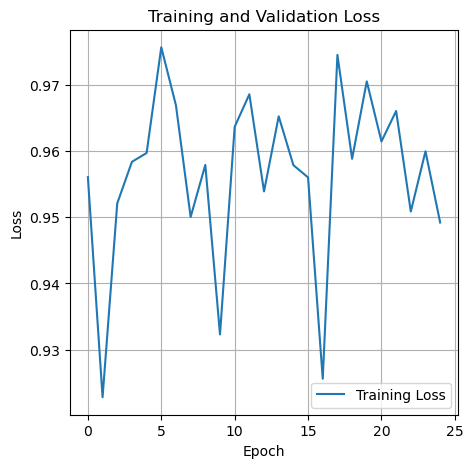

In [108]:
plot_train_loss(res['val_accuracy'])

In [20]:
def get_classification_report(model, dataloader, device=None):
    all_preds = []
    all_labels = []
    all_indices = []
    class_names = [
        "nothing", "one_pair", "two_pair", "three_of_a_kind", "straight",
        "flush", "full_house", "four_of_a_kind", "straight_flush", "royal_flush"
        ]
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            hand, board, labels = [x.to(device) for x in batch] if device is not None else batch
            outputs = model(hand,  board)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            all_indices.extend(range(i * dataloader.batch_size, (i + 1) * dataloader.batch_size))
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    report = classification_report(all_labels, all_preds, target_names=class_names)
    cm = confusion_matrix(all_labels, all_preds)
    return {'report':report, 'confusion_matrix':cm,'labels':all_labels,'pred':all_preds}


In [156]:
res = get_classification_report(model, valloader)

c:\Users\campb\miniconda3\envs\poker_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\campb\miniconda3\envs\poker_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\campb\miniconda3\envs\poker_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [157]:
print(res['report'])

                 precision    recall  f1-score   support

        nothing       0.48      0.31      0.38    308221
       one_pair       0.00      0.00      0.00    259858
       two_pair       0.00      0.00      0.00     29297
three_of_a_kind       0.03      0.24      0.06     12980
       straight       0.00      0.00      0.00      2387
          flush       0.00      0.00      0.00      1230
     full_house       0.00      0.00      0.00       876
 four_of_a_kind       0.00      0.00      0.00       142
 straight_flush       0.00      0.50      0.00        10
    royal_flush       0.00      0.00      0.00         5

       accuracy                           0.16    615006
      macro avg       0.05      0.11      0.04    615006
   weighted avg       0.24      0.16      0.19    615006



In [16]:
class_names = [
        "High Card", "Pair", "Two Pair", "Three of a Kind", "Straight",
        "Flush", "Full House", "Four of a Kind", "Straight Flush", "Royal Flush"
        ]

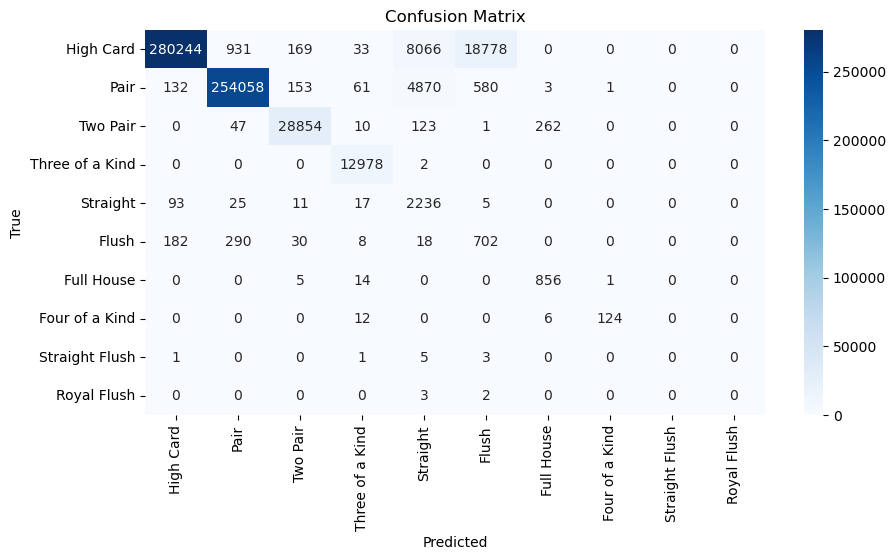

In [24]:
plt.figure(figsize=(10, 5))
sns.heatmap(res['confusion_matrix'], annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
high_mis_flush = (res['labels'] == 0) & (res['pred'] == 5)
indices = [i for i, val in enumerate(high_mis_flush) if val==True]

In [ ]:
from poker_utils.constants import DECK_DICT

In [87]:

num_same_suits = np.zeros(len(indices))
for i, idx in enumerate(indices):
    c = torch.cat(val_dataset[idx][:2])
    c = [i.item() % 4 for i in c if i != -1]
    max_num_same_suit = np.unique(c, return_counts=True)[1].max().item()
    num_same_suits[i] = max_num_same_suit

In [98]:
np.unique(num_same_suits, return_counts=True)

(array([2., 3., 4., 5., 6.]), array([1184, 9480, 8068,   39,    7]))

In [91]:
indices[45]

1208

In [92]:
val_dataset.X.iloc[1208]

card1                 Ah
card1_id              50
card1_treys    268446761
card2                 Kd
card2_id              45
card2_treys    134236965
card3                 7h
card3_id              22
card3_treys      2106637
card4                 Qc
card4_id              40
card4_treys     67144223
card5                 6c
card5_id              16
card5_treys      1082379
Name: 1208, dtype: object

In [93]:
torch.cat(val_dataset[1208][:2])

tensor([50, 45, 40, 16, 22, -1, -1])

In [95]:
print(DECK_DICT[50])
print(DECK_DICT[45])
print(DECK_DICT[40])
print(DECK_DICT[16])
print(DECK_DICT[22])

Ah
Kd
Qc
6c
7h
